In [ ]:
import sys
import json
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

from tensorflow.keras.utils import to_categorical

from keras import backend

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and parse data

In [ ]:
#samples_files = ["2021-11-09-standup-sitdown-stationary-waving-clapping-nodding-walking.samples"]
samples_files = ["2021-11-26-stationary-standup-sitdown-waving-clapping-nodding-walking.samples"]
samples_files = ["/content/drive/MyDrive/data/" + f for f in samples_files]
all_samples_by_file = []

for samples_file in samples_files:
    all_samples = []
    with open(samples_file, "r") as file:
        for line in file.readlines():
            sample = json.loads(line)
            all_samples.append(sample)
    
    all_samples_by_file.append(all_samples)

stations = {next(iter(sample[0].keys())) for sample in all_samples_by_file[0]}

In [ ]:
samples_by_station = {}
for station in stations:
    samples_by_station[station] = []
    for f in all_samples_by_file:
        samples_in_file_for_this_station = []
        for sample in f:
            if sample[0][station]:
                # assume there is a sample of this station in all frames
                frames = []
                for frame in sample:
                    frames.append(frame[station])
                samples_in_file_for_this_station.append(frames)
                
        samples_by_station[station].append(samples_in_file_for_this_station)

In [ ]:
selected_station = next(iter(stations))
# selected_station = "..."

samples = samples_by_station[selected_station] # list of datasets

## Prepare data

#### Configuration

In [ ]:
subcarriers = len(samples[0][0][0]["angles"])
discretized_steps = 72  # -> 5° interval
input_shape = (subcarriers, discretized_steps, 1)
val_pct = 0.2
test_pct = 0.2
class_count = max([int(sample[0]["cl"]) for sample in samples[0]])
frame_count = len(samples[0][0])

use_dists = True
data_layers = 2 if use_dists else 1

if samples[0][0][0]["angles3"] is not None:
    use_multiple_antennas = True
    print("Using 3 TX antennas")
    data_layers *= 3

print(f"Subcarriers {subcarriers}")
print(f"Step Interval:{360/discretized_steps}°, {np.pi * 2.0 / 36} rad")

print(f"Sample size: {frame_count}x{subcarriers}x{discretized_steps}x{data_layers}")
print(f"Classes: {class_count}")
print(f"Frames: {frame_count}")

Using 3 TX antennas
Subcarriers 55
Step Interval:5.0°, 0.17453292519943295 rad
Sample size: 60x55x72x6
Classes: 7
Frames: 60


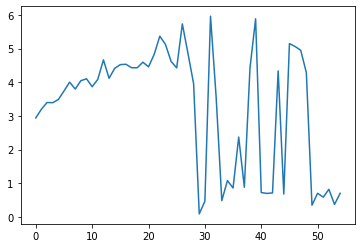

In [ ]:
import matplotlib.pyplot as plt

s = []

sample = samples[0][3][0]
for subcarrier in range(subcarriers):
    s.append(sample["angles"][subcarrier])

plt.plot(s)

In [ ]:
def load_frame(frame):
    x_sample = np.zeros((subcarriers, discretized_steps, data_layers), dtype="float32")
    
    for subcarrier in range(subcarriers):
        offset_per_antenna = 2 if use_dists else 1
        
        for tx_antenna in range(3 if use_multiple_antennas else 1):
            antenna_suffix = "" if tx_antenna == 0 else str(tx_antenna+1)
            
            angle_value = np.floor(frame["angles" + antenna_suffix][subcarrier] / (2.0*np.pi) * discretized_steps)
            x_sample[subcarrier][int(angle_value)][(tx_antenna * offset_per_antenna) + 0] = 1.0
            
            if use_dists:
                dist_value = min(len(x_sample[subcarrier])-1, np.floor(frame["dists" + antenna_suffix][subcarrier] / (2000.0) * discretized_steps))
                x_sample[subcarrier][int(dist_value)][(tx_antenna * offset_per_antenna) + 1] = 1.0

    x_sample.reshape((x_sample.shape[0], x_sample.shape[1], data_layers))
    return x_sample

def load_data(samples):
    shuffled_samples = samples.copy()
    random.shuffle(shuffled_samples)
    
    x_samples = []
    y_samples = []

    for sample in shuffled_samples:
        y_sample = sample[0]["cl"] # assume equal in all frame
        
        x_frames = [load_frame(frame) for frame in sample]
        if len(x_frames) != frame_count:
            print(f"Sample for class {sample[0]['cl']} has too many frames! ({len(x_frames)})", file=sys.stderr)
            x_frames = x_frames[:frame_count]
        #x_frames = [frame.reshape() for frame in x_frames]
        x_sample = np.stack(x_frames, axis=0) # does this work, why is the end result None? Should stack over a new axis
        
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        
    print(f"class_count: {class_count}")

    y_samples = to_categorical(np.array(y_samples) - 1, class_count)
    
    return x_samples, y_samples

In [ ]:
if len(samples) == 1:
    
    x_samples, y_samples = load_data(samples[0])

    sample_count = len(y_samples)
    test_sample_count = int(test_pct * sample_count)
    val_sample_count = int(val_pct * sample_count)
    train_sample_count = sample_count - test_sample_count - val_sample_count

    print(f"{sample_count} samples, {train_sample_count} train, {val_sample_count} validation, {test_sample_count} test")
    
    x_train = x_samples[0:train_sample_count]
    y_train = y_samples[0:train_sample_count]
    x_val = x_samples[train_sample_count:(train_sample_count+val_sample_count)]
    y_val = y_samples[train_sample_count:(train_sample_count+val_sample_count)]
    x_test = x_samples[(train_sample_count+val_sample_count):sample_count]
    y_test = y_samples[(train_sample_count+val_sample_count):sample_count]

    if backend.image_data_format() == 'channels_first':
        x_train = np.array(x_train).reshape(train_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
        x_val = np.array(x_val).reshape(val_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
        x_test = np.array(x_test).reshape(test_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
    else:
        x_train = np.array(x_train).reshape(train_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
        x_val = np.array(x_val).reshape(val_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
        x_test = np.array(x_test).reshape(test_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
elif len(samples) == 2:
    train_samples = samples[0]
    test_samples = samples[1]
    
    # split validation off of train
    #x_train_val, y_train_val = load_data(train_samples)
    #x_test, y_test = load_data(test_samples)
    
    #train_val_count = len(train_samples)
    #test_sample_count = len(test_samples)
    #val_sample_count = int(val_pct * train_val_count)
    #train_sample_count = train_val_count - val_sample_count
    
    #x_train = x_train_val[0:train_sample_count]
    #y_train = y_train_val[0:train_sample_count]
    #x_val = x_train_val[train_sample_count:(train_sample_count+val_sample_count)]
    #y_val = y_train_val[train_sample_count:(train_sample_count+val_sample_count)]

    # split validation off of test
    x_train, y_train = load_data(train_samples)
    x_test_val, y_test_val = load_data(test_samples)
    
    train_count = len(train_samples)
    test_val_count = len(test_samples)
    val_sample_count = int(0.5 * test_val_count)
    test_sample_count = test_val_count - val_sample_count
    train_sample_count = train_count
    
    x_val = x_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    y_val = y_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    x_test = x_test_val[0:test_sample_count]
    y_test = y_test_val[0:test_sample_count]
    
    print(f"{len(train_samples)+len(test_samples)} samples, {train_sample_count} train, {val_sample_count} validation, {test_sample_count} test")
    
    if backend.image_data_format() == 'channels_first':
        x_train = np.array(x_train).reshape(train_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
        x_val = np.array(x_val).reshape(val_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
        x_test = np.array(x_test).reshape(test_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
    else:
        x_train = np.array(x_train).reshape(train_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
        x_val = np.array(x_val).reshape(val_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
        x_test = np.array(x_test).reshape(test_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
elif len(samples) == 3:
    train_samples = samples[0]
    val_samples = samples[1]
    test_samples = samples[2]
    
    # split validation off of train
    #x_train_val, y_train_val = load_data(train_samples)
    #x_test, y_test = load_data(test_samples)
    
    #train_val_count = len(train_samples)
    #test_sample_count = len(test_samples)
    #val_sample_count = int(val_pct * train_val_count)
    #train_sample_count = train_val_count - val_sample_count
    
    #x_train = x_train_val[0:train_sample_count]
    #y_train = y_train_val[0:train_sample_count]
    #x_val = x_train_val[train_sample_count:(train_sample_count+val_sample_count)]
    #y_val = y_train_val[train_sample_count:(train_sample_count+val_sample_count)]

    # split validation off of test
    x_train, y_train = load_data(train_samples)
    x_val, y_val = load_data(val_samples)
    x_test, y_test = load_data(test_samples)
    
    train_count = len(train_samples)
    val_count = len(val_samples)
    test_count = len(test_samples)
    val_sample_count = val_count
    test_sample_count = test_count
    train_sample_count = train_count
    
    #x_val = x_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    #y_val = y_test_val[test_sample_count:(test_sample_count+val_sample_count)]
    #x_test = x_test_val[0:test_sample_count]
    #y_test = y_test_val[0:test_sample_count]
    
    print(f"{len(train_samples)+len(test_samples)} samples, {train_sample_count} train, {val_sample_count} validation, {test_sample_count} test")
    
    if backend.image_data_format() == 'channels_first':
        x_train = np.array(x_train).reshape(train_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
        x_val = np.array(x_val).reshape(val_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
        x_test = np.array(x_test).reshape(test_sample_count, frame_count, data_layers, subcarriers, discretized_steps)
    else:
        x_train = np.array(x_train).reshape(train_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
        x_val = np.array(x_val).reshape(val_sample_count, frame_count, subcarriers, discretized_steps, data_layers)
        x_test = np.array(x_test).reshape(test_sample_count, frame_count, subcarriers, discretized_steps, data_layers)

Sample for class 6 has too many frames! (61)
Sample for class 7 has too many frames! (61)
Sample for class 7 has too many frames! (61)


class_count: 7
280 samples, 168 train, 56 validation, 56 test


In [ ]:
#x_train = x_train[0:1]
#x_val = x_val[0:1]
#x_test = x_test[0:1]
#y_train = y_train[0:1]
#y_val = y_val[0:1]
#y_test = y_test[0:1]

## Model

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from csi_models import SimpleRecursiveModel

model = SimpleRecursiveModel(class_count=class_count, input_shape=input_shape)

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy, 
   optimizer = keras.optimizers.Adadelta(), metrics = ['accuracy'])
model.build(x_train.shape)
model.summary()

Model: "simple_recursive_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  multiple                 432672    
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 multiple                  131584    
                                                                 
 dense_1 (Dense)             multiple                  903       
                                                                 
Total params: 565,159
Trainable params: 565,159
Non-trainable params: 0
_________________________________________________________________


In [ ]:
backend.set_value(model.optimizer.learning_rate, 0.05)

history = model.fit(
   x_train, y_train, 
   batch_size = 64, 
   epochs = 100,
   verbose = 1, 
   validation_data = (x_val, y_val)
)

Epoch 1/100
3/3 [==============================] - 51s 14s/step - loss: 1.9483 - accuracy: 0.1310 - val_loss: 1.9596 - val_accuracy: 0.0714
Epoch 2/100
3/3 [==============================] - 6s 2s/step - loss: 1.9537 - accuracy: 0.0952 - val_loss: 1.9569 - val_accuracy: 0.0714
Epoch 3/100
3/3 [==============================] - 6s 2s/step - loss: 1.9460 - accuracy: 0.1190 - val_loss: 1.9537 - val_accuracy: 0.0714
Epoch 4/100
3/3 [==============================] - 6s 2s/step - loss: 1.9412 - accuracy: 0.1667 - val_loss: 1.9525 - val_accuracy: 0.0893
Epoch 5/100
3/3 [==============================] - 6s 2s/step - loss: 1.9411 - accuracy: 0.1845 - val_loss: 1.9499 - val_accuracy: 0.1250
Epoch 6/100
3/3 [==============================] - 6s 2s/step - loss: 1.9399 - accuracy: 0.1488 - val_loss: 1.9477 - val_accuracy: 0.1071
Epoch 7/100
3/3 [==============================] - 6s 2s/step - loss: 1.9380 - accuracy: 0.1488 - val_loss: 1.9453 - val_accuracy: 0.1250
Epoch 8/100
3/3 [===============

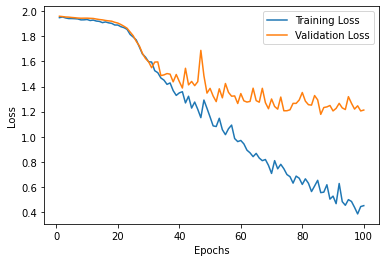

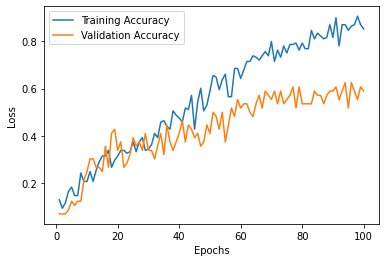

In [ ]:
epochs = range(1, len(history.history['loss'])+1)

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Test

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 1.0702828168869019
Test accuracy: 0.5178571343421936


## Predict

In [ ]:
pred = model.predict(x_test) 
pred = np.argmax(pred, axis = 1)[:30] 
label = np.argmax(y_test,axis = 1)[:30] 

print(pred) 
print(label)

[2 5 1 3 2 4 4 4 0 4 4 1 2 5 4 0 1 2 3 4 1 6 3 2 5 1 5 0 2 3]
[2 6 0 3 2 5 6 2 0 5 4 0 2 5 3 0 1 2 4 4 0 6 4 3 5 4 5 0 2 3]


In [ ]:
pred = model.predict(x_test)
pred = pred[:10] 
label = y_test[:10] 

print(np.round(pred, decimals = 3)) 
print(label)

[[0.    0.001 0.893 0.032 0.066 0.004 0.002]
 [0.001 0.001 0.001 0.023 0.023 0.584 0.367]
 [0.037 0.935 0.005 0.019 0.001 0.002 0.   ]
 [0.003 0.18  0.137 0.385 0.279 0.015 0.002]
 [0.    0.001 0.927 0.023 0.045 0.002 0.003]
 [0.    0.001 0.006 0.08  0.657 0.208 0.049]
 [0.    0.01  0.031 0.262 0.563 0.041 0.092]
 [0.001 0.009 0.12  0.142 0.65  0.049 0.028]
 [0.658 0.26  0.016 0.059 0.002 0.004 0.001]
 [0.002 0.001 0.031 0.326 0.419 0.217 0.003]]
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
